In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [2]:
#This is 2023 data
data = pd.read_csv("ES_2020-4192024.csv")
data.head()

,Date,Session,Time,Open,High,Low,Last,Volume,# of Trades,OHLC Avg,...,deltaHigh,deltaLow,deltaClose,100% Ext,50% Ext,IBH,IB,IBL,-50% Ext,-100% Ext
0,1/2/2023,GBX,17:00:00.000000,3895.00,3900.00,3883.25,3883.75,6592,3666,3890.50,...,-1054,-1681,-1634,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/2/2023,GBX,17:05:00.000000,3883.75,3890.25,3883.50,3885.00,2956,2199,3885.63,...,265,-28,-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/2/2023,GBX,17:10:00.000000,3885.00,3885.50,3875.75,3876.50,3392,2424,3880.69,...,23,-468,-260,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/2/2023,GBX,17:15:00.000000,3876.50,3877.25,3872.75,3874.25,2420,1825,3875.19,...,71,-165,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/2/2023,GBX,17:20:00.000000,3874.00,3875.75,3871.00,3872.75,1563,1241,3873.38,...,77,-218,-123,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Da Plan:
### - I am personally interested in overnight levels and ON fakes. I define ON fake (atleast on NQ) as we tag ON and quickly fade the move. Usually the tag is 5 - 10 points ish. Sometimes we get ON fake fakes, where we look like we are about to tag an ON level but we don't and we quickly move away from it. 

### Based off this, I started noticing somethings, but it would be faster to just go through the data and check stuff out.

### Some of my noticings / questions:

### ON Fake where we tag, we usually tag by a few points and reverse. I want to see how many times is that the HoD or LoD. 

### Does time when ONH/L is put in matter? A lot of the time we get fakes when it gets put in in the morning.

### How many times do we open near an extreme and then move away from it? (How many times do we open at it, and then of those times how many times do we fake fake). 

### Does a fake fake result in a trend day? Do we close far from open?

### If we close below a fake OR fake fake, how many times do we get a retest of it?

### If we fake where do we close? 

### If we fake fake how many times do we tag the other ON extreme?

In [3]:
#First task is making so that I can make a data structure that correctly parses through the df and then gathers ON levels
#and RTH levels.

#Then we can re-iterate through the df and then go through the RTH candles to see if it does the behaviours listed above (use
#temp variables)

#Thinking data structure will be [sessionstring,glbx,rth]
# glbx = (o,h,l,c)
# rth = (o,h,l,c)
#Again will use dictionary. Key will be.... date string? of glbx. So 1/2/2023. Marks start of glbx and session before RTH.

In [4]:
#Really hope the data is formatted properly
#Loop through dates. For each date, check session type. create key in dictionary if not found. track open if no key detected. 
#Always keep track of close of candle for the last 5min candle for glbx close. Same for high and low of candle.
#RTH will always be after the glbx, year starts with glbx. So, if session RTH (keep a boolean variable to check if its the 
#first of a session), keep track of o,h,l,c in the same manner. At the end of the rth update data structure.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70629 entries, 0 to 70628
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          70629 non-null  object 
 1   Session       70629 non-null  object 
 2    Time         70629 non-null  object 
 3    Open         70629 non-null  float64
 4    High         70629 non-null  float64
 5    Low          70629 non-null  float64
 6    Last         70629 non-null  float64
 7    Volume       70629 non-null  int64  
 8    # of Trades  70629 non-null  int64  
 9    OHLC Avg     70629 non-null  float64
 10   HLC Avg      70629 non-null  float64
 11   HL Avg       70629 non-null  float64
 12   Bid Volume   70629 non-null  int64  
 13   Ask Volume   70629 non-null  int64  
 14  30S-ORH       70629 non-null  float64
 15  30S-ORM       70629 non-null  float64
 16  30S-ORL       70629 non-null  float64
 17   deltaOpen    70629 non-null  int64  
 18   deltaHigh    70629 non-nu

In [6]:
if data[" Time"].iloc[0] == " 17:00:00.000000":
    print("yes")
else:
    print("No")
    
if data[" Time"].iloc[88] < " 17:00:00.000000":
    print("yes")
else:
    print("No")

yes
yes


In [7]:
levels = {}

onGlobex = 0
onRTH = 1
ONH = None
ONL = None
ONO = None
ONC = None

RTHH = None
RTHL = None
RTHO = None
RTHC = None

#StartSessionDate too keep track of comment below
SSD = None

for idx, date in enumerate(data['Date']):
    
    #will only create a key if it doesn't exist and its a new RTH
    
#     if(idx == 13980):
#         print(data[' Time'].iloc[idx])
#         print(levels.get(date))
    if (levels.get(date) == None and data[' Time'].iloc[idx] == " 17:00:00.000000") or (levels.get(date) == None and data[' Time'].iloc[idx] == " 19:10:00.000000" and data['Date'].iloc[idx] == '3/14/2023'):
        #print("Inside")
        levels[date] = []
        #Create string sessionstart
        levels[date].append(date + "-")
        #Record values
        ONH = data[' High'].iloc[idx]
        ONL = data[' Low'].iloc[idx]
        ONO = data[' Last'].iloc[idx]
        SSD = date
            
        
    #Second and onwards GBX row for new date
    if ((data[' Time'].iloc[idx] >= " 17:00:00.000000") or (data[' Time'].iloc[idx] < " 15:00:00.000000")) and data['Session'].iloc[idx] == "GBX":
        #Constantly check for new highs and lows.
        
        try:
            if data[' High'].iloc[idx] > ONH:
                ONH = data[' High'].iloc[idx]
            if data[' Low'].iloc[idx] < ONL:
                ONL = data[' Low'].iloc[idx]
        except:
            print(idx)
            print(ONH)
        #Check for last candle and get close and update data structure
        if data[' Time'].iloc[idx] == " 08:25:00.000000":
            ONC = data[' Last'].iloc[idx]
            globex_tuple = (ONO,ONH,ONL,ONC)
            levels[SSD].append(globex_tuple)
            #Complete String
            levels[SSD][0] = levels[SSD][0] + date
            ONH = None
            ONL = None
            ONO = None
            ONC = None
            
    elif (data[' Time'].iloc[idx] >= " 08:30:00.000000" and data[' Time'].iloc[idx] < " 15:00:00.000000") and (data['Session'].iloc[idx] == "RTH"):
        #print("ooga")
        #initialize
        #print(data[' Time'].iloc[idx] > )
        if data[' Time'].iloc[idx] == " 08:30:00.000000":
            RTHH = data[' High'].iloc[idx]
            RTHL = data[' Low'].iloc[idx]
            RTHO = data[' Open'].iloc[idx]
            #print("inside")
        else:
        
            #Constantly check for new highs and lows.
            if data[' High'].iloc[idx] > RTHH:
                RTHH = data[' High'].iloc[idx]
            if data[' Low'].iloc[idx] < RTHL:
                RTHL = data[' Low'].iloc[idx]

            if data[' Time'].iloc[idx] == " 14:55:00.000000":
                RTHC = data[' Last'].iloc[idx]
                rth_tuple = (RTHO,RTHH,RTHL,RTHC)
                levels[SSD].append(rth_tuple)
                RTHH = None
                RTHL = None
                RTHO = None
                RTHC = None
            
print(levels)
    

{'1/2/2023': ['1/2/2023-1/3/2023', (3883.75, 3906.75, 3842.75, 3881.0), (3881.0, 3901.5, 3814.5, 3844.75)], '1/3/2023': ['1/3/2023-1/4/2023', (3841.75, 3870.0, 3839.25, 3868.75), (3869.0, 3896.25, 3836.5, 3873.75)], '1/4/2023': ['1/4/2023-1/5/2023', (3870.75, 3885.5, 3843.75, 3852.5), (3852.75, 3853.5, 3822.5, 3829.0)], '1/5/2023': ['1/5/2023-1/6/2023', (3834.0, 3876.25, 3819.0, 3861.5), (3861.25, 3928.75, 3829.0, 3916.25)], '1/8/2023': ['1/8/2023-1/9/2023', (3922.5, 3941.25, 3916.5, 3939.75), (3939.5, 3973.25, 3911.75, 3913.75)], '1/9/2023': ['1/9/2023-1/10/2023', (3912.5, 3915.75, 3891.5, 3907.5), (3907.5, 3942.0, 3897.25, 3941.75)], '1/10/2023': ['1/10/2023-1/11/2023', (3939.25, 3960.25, 3934.5, 3957.5), (3957.5, 3990.75, 3948.75, 3989.75)], '1/11/2023': ['1/11/2023-1/12/2023', (3989.75, 4021.5, 3954.0, 4000.25), (3999.75, 4018.5, 3957.25, 4002.75)], '1/12/2023': ['1/12/2023-1/13/2023', (4001.25, 4008.25, 3961.75, 3968.25), (3968.25, 4024.25, 3965.75, 4017.75)], '1/15/2023': ['1/15/

In [8]:
#That took way too long to figure out.

In [9]:
#Now lets fist start with this. How many days does does an ONFake occur (lets say 10 points) (we shall record the dates too).

#This means for an ONH fake, RTHO < ONH AND RTHH > ONH AND RTHH - ONH <= 10
#We can get a list of the dates given this.

#For ONL fake, RTHO > ONL AND RTHL < ONL AND ONL - RTHL <= 10


ONH_fake_list = []
ONL_fake_list = []
fake_limit = 5

for key, value in levels.items():
    #Check ONH stat:
    try:
        if (levels[key][2][0] < levels[key][1][1]) and (levels[key][2][1] > levels[key][1][1]) and (levels[key][2][1] - levels[key][1][1] <= fake_limit):
            ONH_fake_list.append(key)
        
        if (levels[key][2][0] > levels[key][1][2]) and (levels[key][1][2] - levels[key][2][2] <= fake_limit) and (levels[key][1][2] > levels[key][2][2]):
            ONL_fake_list.append(key)
    except:
        print(key)
    
        
print("# of days ONH faked by ", fake_limit, "pts: ", len(ONH_fake_list))
print("# of days ONL faked by ", fake_limit, "pts: ", len(ONL_fake_list))
print(len(levels))

1/15/2023
2/19/2023
4/6/2023
5/28/2023
6/18/2023
7/2/2023
7/3/2023
9/3/2023
11/22/2023
11/23/2023
# of days ONH faked by  5 pts:  26
# of days ONL faked by  5 pts:  36
258


In [10]:
#for fake fake similar logic

#ONH fake fake: RTHO < ONH AND RTHH < ONH AND ONH - RTHH <= fake_fake_limit
#ONL fake fake: RTHO > ONL AND RTHL > ONL AND RTHL - ONL <= fake_fake_limit

fake_limit = 5

ONH_fake_fake_list = []
ONL_fake_fake_list = []

for key, value in levels.items():
    #Check ONH stat:
    try:
        if (levels[key][2][0] < levels[key][1][1]) and (levels[key][2][1] < levels[key][1][1]) and (levels[key][1][1] - levels[key][2][1]  <= fake_limit):
            ONH_fake_fake_list.append(key)
        
        if (levels[key][2][0] > levels[key][1][2]) and (levels[key][1][2] < levels[key][2][2]) and (levels[key][2][2] - levels[key][1][2] <= fake_limit):
            ONL_fake_fake_list.append(key)
    except:
        print(key)
    
        
print("# of days ONH faked faked by ", fake_limit, "pts: ", len(ONH_fake_fake_list))
print("# of days ONL faked faked by ", fake_limit, "pts: ", len(ONL_fake_fake_list))
print(len(levels))

1/15/2023
2/19/2023
4/6/2023
5/28/2023
6/18/2023
7/2/2023
7/3/2023
9/3/2023
11/22/2023
11/23/2023
# of days ONH faked faked by  5 pts:  31
# of days ONL faked faked by  5 pts:  39
258


In [11]:
ONH_plays = set(ONH_fake_list + ONH_fake_fake_list)
ONL_plays = set(ONL_fake_list + ONL_fake_fake_list)

print("# of days ONH play by ", fake_limit, "pts: ", len(ONH_plays))
print("# of days ONL play by ", fake_limit, "pts: ", len(ONL_plays))


print("# of days of only one ON limit play: ", len(set(list(ONH_plays) + list(ONL_plays))))

# of days ONH play by  5 pts:  57
# of days ONL play by  5 pts:  75
# of days of only one ON limit play:  117


In [12]:
#Thinking data structure will be [sessionstring,glbx,rth]
# glbx = (o,h,l,c)
# rth = (o,h,l,c)

levels_t = {}

onGlobex = 0
onRTH = 1
ONH = None
ONL = None
ONO = None
ONC = None

RTHH = None
RTHL = None
RTHO = None
RTHC = None

#StartSessionDate too keep track of comment below
SSD = None

for idx, date in enumerate(data['Date']):
    
    #will only create a key if it doesn't exist and its a new RTH
    
#     if(idx == 13980):
#     print(data[' Time'].iloc[idx])
#     print(levels_t.get(date))
    if (levels_t.get(date) == None and data[' Time'].iloc[idx] == " 15:00:00.000000") or (levels_t.get(date) == None and data[' Time'].iloc[idx] == " 19:10:00.000000" and data['Date'].iloc[idx] == '3/14/2023') or (levels_t.get(date) == None and data[' Time'].iloc[idx] == " 17:00:00.000000" and data['Date'].iloc[idx] == '1/2/2023'):
        #print("Inside")
        levels_t[date] = []
        #Create string sessionstart
        levels_t[date].append(date + "-")
        #Record values
        ONH = data[' High'].iloc[idx]
        ONL = data[' Low'].iloc[idx]
        ONO = data[' Last'].iloc[idx]
        SSD = date
            
        
    #Second and onwards GBX row for new date
    if (data[' Time'].iloc[idx] >= " 15:00:00.000000") or ((data[' Time'].iloc[idx] < " 15:00:00.000000") and (data['Session'].iloc[idx] == "GBX")):
        #Constantly check for new highs and lows.
        
        try:
            if data[' High'].iloc[idx] > ONH:
                ONH = data[' High'].iloc[idx]
            if data[' Low'].iloc[idx] < ONL:
                ONL = data[' Low'].iloc[idx]
        except:
            print(idx)
            print(ONH)
        #Check for last candle and get close and update data structure
        if data[' Time'].iloc[idx] == " 08:25:00.000000":
            ONC = data[' Last'].iloc[idx]
            globex_tuple = (ONO,ONH,ONL,ONC)
            levels_t[SSD].append(globex_tuple)
            #Complete String
            levels_t[SSD][0] = levels_t[SSD][0] + date
            ONH = None
            ONL = None
            ONO = None
            ONC = None
            
    elif (data[' Time'].iloc[idx] >= " 08:30:00.000000" and data[' Time'].iloc[idx] < " 15:00:00.000000") and (data['Session'].iloc[idx] == "RTH"):
        #print("ooga")
        #initialize
        #print(data[' Time'].iloc[idx] > )
        if data[' Time'].iloc[idx] == " 08:30:00.000000":
            RTHH = data[' High'].iloc[idx]
            RTHL = data[' Low'].iloc[idx]
            RTHO = data[' Open'].iloc[idx]
            #print("inside")
        else:
        
            #Constantly check for new highs and lows.
            if data[' High'].iloc[idx] > RTHH:
                RTHH = data[' High'].iloc[idx]
            if data[' Low'].iloc[idx] < RTHL:
                RTHL = data[' Low'].iloc[idx]

            if data[' Time'].iloc[idx] == " 14:55:00.000000":
                RTHC = data[' Last'].iloc[idx]
                rth_tuple = (RTHO,RTHH,RTHL,RTHC)
                levels_t[SSD].append(rth_tuple)
                RTHH = None
                RTHL = None
                RTHO = None
                RTHC = None
            
print(levels_t)
    

2712
None
2713
None
2714
None
2715
None
2716
None
2717
None
2718
None
2719
None
2720
None
2721
None
2722
None
2723
None
2724
None
2725
None
2726
None
2727
None
2728
None
2729
None
2730
None
2731
None
2732
None
2733
None
2734
None
2735
None
2736
None
2737
None
2738
None
2739
None
2740
None
2741
None
2742
None
2743
None
2744
None
2745
None
2746
None
2747
None
2748
None
2749
None
2750
None
2751
None
2752
None
2753
None
2754
None
2755
None
2756
None
2757
None
2758
None
2759
None
2760
None
2761
None
2762
None
2763
None
2764
None
2765
None
2766
None
2767
None
2768
None
2769
None
2770
None
2771
None
2772
None
2773
None
2774
None
2775
None
2776
None
2777
None
2778
None
2779
None
2780
None
2781
None
2782
None
2783
None
2784
None
2785
None
2786
None
2787
None
2788
None
2789
None
2790
None
2791
None
2792
None
2793
None
2794
None
2795
None
2796
None
2797
None
2798
None
2799
None
2800
None
2801
None
2802
None
2803
None
2804
None
2805
None
2806
None
2807
None
2808
None
2809
None
2810
None
2811
None


47848
None
47849
None
47850
None
47851
None
47852
None
47853
None
47854
None
47855
None
47856
None
47857
None
47858
None
47859
None
47860
None
47861
None
47862
None
47863
None
47864
None
47865
None
47866
None
47867
None
47868
None
47869
None
47870
None
47871
None
47872
None
47873
None
47874
None
47875
None
47876
None
47877
None
47878
None
47879
None
47880
None
47881
None
47882
None
47883
None
47884
None
47885
None
47886
None
47887
None
47888
None
47889
None
47890
None
47891
None
47892
None
47893
None
47894
None
47895
None
47896
None
47897
None
47898
None
47899
None
47900
None
47901
None
47902
None
47903
None
47904
None
47905
None
47906
None
47907
None
47908
None
47909
None
47910
None
47911
None
47912
None
47913
None
47914
None
47915
None
47916
None
47917
None
47918
None
47919
None
47920
None
47921
None
47922
None
47923
None
47924
None
47925
None
47926
None
47927
None
47928
None
47929
None
47930
None
47931
None
47932
None
47933
None
47934
None
47935
None
47936
None
47937
None
47938
None

# GAP BASED OFF RTHH

In [13]:
# Gap day up/down check:
#Loop through dictionary. If index = 0, record RTH H and low, key in temp tuple (prior_day_key, yRTHH, yRTHL). 
# If index > 0, record RTHO. If RTHO > RTHH add to gap dictionary, key as current day. Value (prior_day_key, RTHO, yRTHH)
#Updated temp tuple with new values.

#Thinking data structure will be [sessionstring,glbx,rth]
# glbx = (o,h,l,c)
# rth = (o,h,l,c)


gap_up_days = {}
gap_down_days = {}

high_low = None

for key, value in levels_t.items():
    if(key == "1/2/2023"):
        high_low = (key,value[2][1],value[2][2])
        continue
        
    else:
        try:
            if value[2][0] > high_low[1]:
                gap_up_days[key] = (high_low[0], value[2][0], high_low[1])
            elif value[2][0] < high_low[2]:
                gap_down_days[key] = (high_low[0], value[2][0], high_low[2])
            
        except:
            print(key)
        try:    
            high_low = (key,value[2][1], value[2][2])
        except:
            print(key)

print(len(gap_up_days))
print(len(gap_down_days))
print(len(levels_t))

print(gap_up_days)

1/13/2023
1/17/2023
2/17/2023
2/21/2023
5/26/2023
5/30/2023
6/16/2023
6/20/2023
6/30/2023
7/5/2023
9/1/2023
9/5/2023
11/22/2023
11/27/2023
12/29/2023
12/29/2023
62
34
249
{'1/5/2023': ('1/4/2023', 3861.25, 3853.5), '1/6/2023': ('1/5/2023', 3939.5, 3928.75), '1/10/2023': ('1/9/2023', 3957.5, 3942.0), '1/11/2023': ('1/10/2023', 3999.75, 3990.75), '1/20/2023': ('1/19/2023', 3996.5, 3990.5), '1/25/2023': ('1/24/2023', 4059.0, 4035.75), '2/1/2023': ('1/31/2023', 4173.75, 4163.25), '2/10/2023': ('2/9/2023', 4107.0, 4104.25), '2/22/2023': ('2/21/2023', 4028.5, 4025.0), '2/24/2023': ('2/23/2023', 4010.25, 3984.0), '3/2/2023': ('3/1/2023', 4005.0, 3995.25), '3/3/2023': ('3/2/2023', 4057.75, 4053.0), '3/13/2023': ('3/10/2023', 3943.25, 3940.5), '3/20/2023': ('3/17/2023', 4020.0, 3989.5), '3/24/2023': ('3/23/2023', 4026.0, 4003.5), '3/28/2023': ('3/27/2023', 4044.5, 4009.5), '3/29/2023': ('3/28/2023', 4085.0, 4061.25), '3/30/2023': ('3/29/2023', 4090.25, 4087.75), '4/3/2023': ('3/31/2023', 4160.2

# GAP BASED OFF CLOSE:

In [27]:
# Gap day up/down check:
#Loop through dictionary. If index = 0, record RTH H and low, key in temp tuple (prior_day_key, yRTHH, yRTHL). 
# If index > 0, record RTHO. If RTHO > RTHH add to gap dictionary, key as current day. Value (prior_day_key, RTHO, yRTHH)
#Updated temp tuple with new values.

#Thinking data structure will be [sessionstring,glbx,rth]
# glbx = (o,h,l,c)
# rth = (o,h,l,c)

#('11/2/2023', 4382.5, 4375.0)

gap_up_days = {}
gap_down_days = {}

open_close = None

for key, value in levels_t.items():
    if(key == "1/2/2023"):
        open_close = (key,value[2][0],value[2][3])
        continue
        
    else:
        try:
            if open_close[2] > open_close[1]:
                #print("hel")
                if value[2][0] > open_close[2]:
                    #key is globex to rth start date. 
                    #So 11/3/2023 key gives 
#('11/2/2023' (key of prior RTH session where we get close for gap up(open_close tuple)), 4382.5 11/6 open, 11/3 close 4375.0)
                    gap_up_days[key] = (open_close[0], value[2][0], open_close[2])
            elif open_close[2] < open_close[1]:
                if value[2][0] < open_close[2]:
                    gap_down_days[key] = (open_close[0], value[2][0], open_close[1])
            
        except:
            print(key)
        try:    
            open_close = (key,value[2][0], value[2][3])
        except:
            print(key)

print(len(gap_up_days))
print(len(gap_down_days))
print(len(levels_t))

print(gap_up_days)

1/13/2023
1/17/2023
2/17/2023
2/21/2023
5/26/2023
5/30/2023
6/16/2023
6/20/2023
6/30/2023
7/5/2023
9/1/2023
9/5/2023
11/22/2023
11/27/2023
12/29/2023
12/29/2023
68
40
249
{'1/6/2023': ('1/5/2023', 3939.5, 3916.25), '1/10/2023': ('1/9/2023', 3957.5, 3941.75), '1/11/2023': ('1/10/2023', 3999.75, 3989.75), '1/20/2023': ('1/19/2023', 3996.5, 3987.75), '1/25/2023': ('1/24/2023', 4059.0, 4032.5), '2/1/2023': ('1/31/2023', 4173.75, 4134.5), '2/10/2023': ('2/9/2023', 4107.0, 4100.0), '2/24/2023': ('2/23/2023', 4010.25, 3975.75), '3/2/2023': ('3/1/2023', 4005.0, 3986.25), '3/3/2023': ('3/2/2023', 4057.75, 4049.25), '3/8/2023': ('3/7/2023', 4002.5, 3995.5), '3/13/2023': ('3/10/2023', 3943.25, 3889.0), '3/20/2023': ('3/17/2023', 4020.0, 3984.5), '3/24/2023': ('3/23/2023', 4026.0, 4002.5), '3/29/2023': ('3/28/2023', 4085.0, 4058.75), '4/3/2023': ('3/31/2023', 4160.25, 4153.5), '4/10/2023': ('4/6/2023', 4142.25, 4137.5), '4/17/2023': ('4/14/2023', 4193.5, 4177.25), '4/20/2023': ('4/19/2023', 4155.7

In [15]:
rsdf = pd.read_csv("F:\\jupyter_workspace\\Trade Analysis\\RS_ES_Stats_ES.csv")
rsdf.head()

,Unnamed: 0,Date,Open,Max,Min,Close,Playbook,EOD,UP,DOWN,...,HP,Open From HP,Close From HP,Open from MHP,Close From MHP,open above,close above,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,1/3/2023,3881,3901.50,3814.50,3839.25,BRLU,-41.75,20.50,-66.50,...,3867.0,14.00,-27.75,70.00,28.25,1.0,0,0,NaN,0.0
1,2,1/4/2023,3869,3896.25,3836.50,3874.00,BLU,5.00,27.25,-32.50,...,3862.0,7.00,12.00,83.00,88.00,1.0,1,1,NaN,0.0
2,3,1/5/2023,3852.75,3853.50,3822.50,3831.00,BRLU,-21.75,0.75,-30.25,...,3840.0,12.75,-9.00,68.75,47.00,1.0,0,0,NaN,0.0
3,4,1/6/2023,3861.25,3928.75,3829.00,3911.25,BSU,50.00,67.50,-32.25,...,3860.0,1.25,51.25,77.25,127.25,1.0,1,1,NaN,0.0
4,5,1/9/2023,3939.5,3973.25,3909.75,3911.50,BLU,-28.00,33.75,-29.75,...,3905.0,34.50,6.50,105.50,77.50,1.0,1,1,NaN,0.0


### I want to see if there is any statistical correlations with gaps not being filled given a RS day.
### Can do this with a log reg.

### Train model last.

### First we can just try to see if theres a correlation. Pie graph shit. #of days we gapped up what was the play, 
### where was half gap and where was MHP. 

### Of pie graph i want to see when we gap up what is the play of the day. From there we move

In [16]:
def extract_RTH_date(session):
    try:
        date = session.split("-")[1]
        return date
    except:
        print("Invalid session string")
        return None

In [17]:
#Loop trhough gap up days array
#For each gap up day, access levels_t dict with key, and extract session string
#Once extract session string, match date in RS chart. 
# Add to dictionary keeping count of #s of plays

gu_plays = {}
blu_dates = []

for date, value in gap_up_days.items():
    #extract session string
    rth_date = extract_RTH_date(levels_t[date][0])
    #print(rth_date)
    playbook = rsdf[rsdf["Date"] == rth_date]["Playbook"].iloc[0]
    
    gu_plays[playbook] = gu_plays.get(playbook, 0) + 1
    if playbook == "BLU":
        blu_dates.append(rth_date)

{'BLU': 48, 'MRLU': 6, 'BLD': 3, 'MRSU': 2, 'BRSU': 2, 'MRLD': 1, nan: 2, 'BRLU': 1, 'BSU': 3}


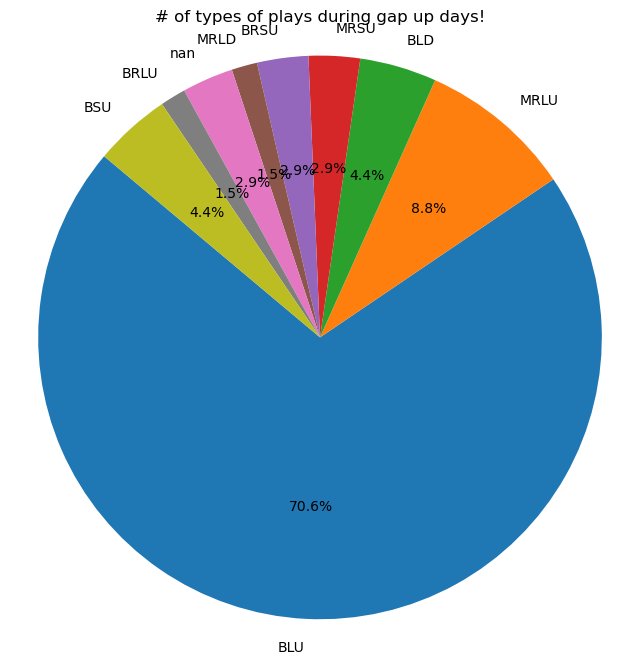

In [18]:
# Extracting labels and sizes
labels = list(gu_plays.keys())
sizes = list(gu_plays.values())

print(gu_plays)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title('# of types of plays during gap up days!')

# Showing the plot
plt.show()

### Next, I want to check on the BLU days of gap ups, what is the LOD in relation to the gap. What % of time is LOD below yRTHH, in between yRTHH and half gap, in between half gap and open. Then after for each section ill get the average % distance travelled. 

### Would also like to know the average or most common time ranges LOD is put in.... (thats difficult)

#### wait so 
u want me to check whats the playbook on the days we full gap fill
whats the playbook we half gap
and then depending on the playbook ratios predict if halfgap is LOD

In [19]:
#Thinking data structure will be [sessionstring,glbx,rth]
# glbx = (o,h,l,c)
# rth = (o,h,l,c)
#Value (prior_day_key, RTHO, yRTHH)

below_H = {}
below_H_time = {}
H_HG = {}
H_HG_time = {}
HG = {}
HG_time = {}

for date, value in gap_up_days.items():
    #extract session string
    rth_date = extract_RTH_date(levels_t[date][0])
    #print(rth_date)
    playbook = rsdf[rsdf["Date"] == rth_date]["Playbook"].iloc[0]
    #using rth_date, LOD, get first candle instance time.
    time_LOD = data[(data["Date"] == rth_date) & (data[" Low"] == levels_t[date][2][2]) & (data["Session"] == "RTH")][" Time"].iloc[0]
    
    #if LOD < yRTHH the add to blod. elif elif 
#     try:
        
#         #print((((value[1] - value[2]) / 2) + value[2]))
#         if levels_t[date][2][2] < value[2]:
#             below_H[playbook] = below_H.get(playbook, 0) + 1
#             below_H_time[playbook] = below_H_time.get(playbook, [])
#             below_H_time[playbook].append(time_LOD)
#         elif level_t[date][2][2] > value[2] and (level_t[date][2][2] < (((value[1] - value[2]) / 2) + value[2])):
#             print("SDASDASDASD")
#             H_HG[playbook] = H_HG.get(playbook, 0) + 1
#             H_HG_time[playbook] = H_HG_time.get(playbook, [])
#             H_HG_time[playbook].append(time_LOD)
#         elif level_t[date][2][2] >= (((value[1] - value[2]) / 2) + value[2]):
#             HG[playbook] = HG.get(playbook, 0) + 1
#             HG_time[playbook] = HG_time.get(playbook,[])
#             HG_time[playbook].append(time_LOD)
#     except:
#         print(date)
#         print(value)
#         print(levels_t[date])
#         continue



        
    #print((((value[1] - value[2]) / 2) + value[2]))
    if levels_t[date][2][2] < value[2]:
        print(date)
        below_H[playbook] = below_H.get(playbook, 0) + 1
        below_H_time[playbook] = below_H_time.get(playbook, [])
        below_H_time[playbook].append(time_LOD)
    elif levels_t[date][2][2] > value[2] and (levels_t[date][2][2] < (((value[1] - value[2]) / 2) + value[2])):
        #print("SDASDASDASD")
        H_HG[playbook] = H_HG.get(playbook, 0) + 1
        H_HG_time[playbook] = H_HG_time.get(playbook, [])
        H_HG_time[playbook].append(time_LOD)
    elif levels_t[date][2][2] >= (((value[1] - value[2]) / 2) + value[2]):
        HG[playbook] = HG.get(playbook, 0) + 1
        HG_time[playbook] = HG_time.get(playbook,[])
        HG_time[playbook].append(time_LOD)

print(gap_up_days["11/3/2023"])
print(levels_t["11/3/2023"])
#So 11/3/2023 key gives 
#('11/2/2023' (key of prior RTH session where we get close for gap up(open_close tuple)), 4382.5 11/6 open, 11/3 close 4375.0)

1/6/2023
1/11/2023
1/20/2023
1/25/2023
3/3/2023
3/8/2023
3/24/2023
4/3/2023
4/10/2023
4/17/2023
4/20/2023
5/5/2023
5/11/2023
5/18/2023
6/2/2023
6/6/2023
6/8/2023
6/13/2023
6/15/2023
7/10/2023
7/13/2023
7/26/2023
7/28/2023
8/3/2023
8/8/2023
8/18/2023
8/21/2023
8/23/2023
8/29/2023
8/30/2023
9/19/2023
9/28/2023
10/10/2023
10/11/2023
10/30/2023
11/3/2023
11/7/2023
11/28/2023
12/5/2023
12/12/2023
12/13/2023
12/21/2023
('11/2/2023', 4382.5, 4375.0)
['11/3/2023-11/6/2023', (4378.25, 4386.75, 4374.0, 4382.5), (4382.5, 4389.5, 4364.25, 4384.5)]


In [20]:
print(below_H)
print()
print(H_HG)
print()
print(HG)
print()

{'BLU': 27, 'MRSU': 2, 'BRSU': 1, 'MRLU': 4, 'MRLD': 1, 'BLD': 2, nan: 1, 'BRLU': 1, 'BSU': 3}

{'BLU': 10, 'MRLU': 1, 'BRSU': 1, nan: 1}

{'BLD': 1, 'BLU': 10, 'MRLU': 1}



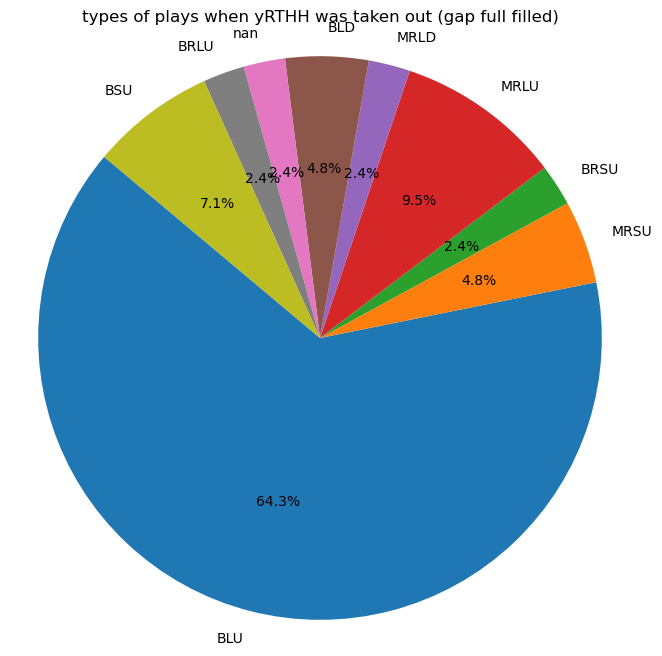

In [21]:
# Extracting labels and sizes
labels = list(below_H.keys())
sizes = list(below_H.values())


# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title('types of plays when yRTHH was taken out (gap full filled)')

# Showing the plot
plt.show()

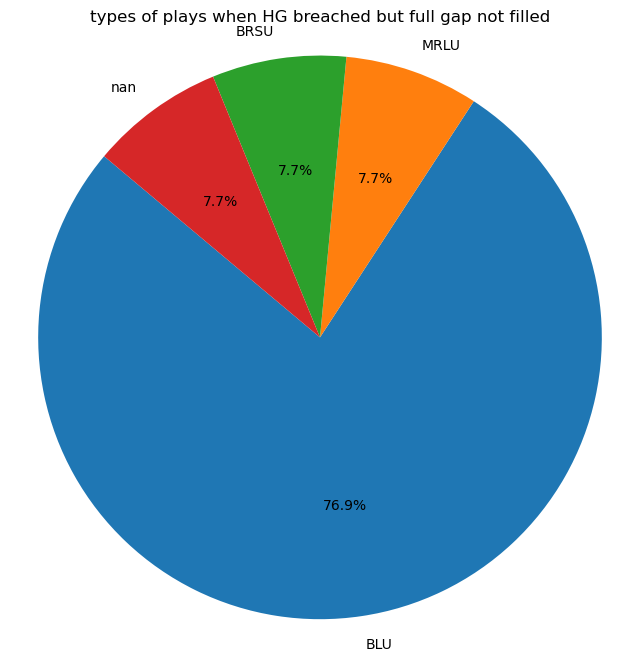

In [22]:
# Extracting labels and sizes
labels = list(H_HG.keys())
sizes = list(H_HG.values())


# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title('types of plays when HG breached but full gap not filled')

# Showing the plot
plt.show()

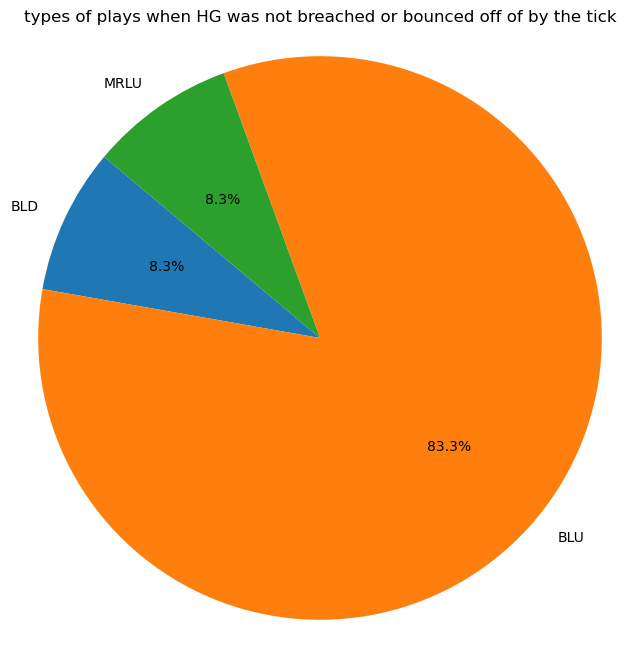

In [23]:
# Extracting labels and sizes
labels = list(HG.keys())
sizes = list(HG.values())


# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title('types of plays when HG was not breached or bounced off of by the tick')

# Showing the plot
plt.show()

In [24]:
print(below_H_time)
print()
print(H_HG_time)
print()
print(HG_time)
print()

{'BLU': [' 14:45:00.000000', ' 08:50:00.000000', ' 08:30:00.000000', ' 09:55:00.000000', ' 14:30:00.000000', ' 10:55:00.000000', ' 11:20:00.000000', ' 09:45:00.000000', ' 10:40:00.000000', ' 13:00:00.000000', ' 13:30:00.000000', ' 12:35:00.000000', ' 11:00:00.000000', ' 13:05:00.000000', ' 09:05:00.000000', ' 14:50:00.000000', ' 14:45:00.000000', ' 14:45:00.000000', ' 09:25:00.000000', ' 14:55:00.000000', ' 13:30:00.000000', ' 12:35:00.000000', ' 13:15:00.000000', ' 14:40:00.000000', ' 14:50:00.000000', ' 12:15:00.000000', ' 13:30:00.000000'], 'MRSU': [' 14:20:00.000000', ' 14:50:00.000000'], 'BRSU': [' 09:45:00.000000'], 'MRLU': [' 13:05:00.000000', ' 09:00:00.000000', ' 12:20:00.000000', ' 11:05:00.000000'], 'MRLD': [' 10:35:00.000000'], 'BLD': [' 14:55:00.000000', ' 12:50:00.000000'], nan: [' 14:45:00.000000'], 'BRLU': [' 10:55:00.000000'], 'BSU': [' 10:50:00.000000', ' 14:55:00.000000', ' 14:55:00.000000']}

{'BLU': [' 09:55:00.000000', ' 09:10:00.000000', ' 14:35:00.000000', ' 12:

In [25]:
def extract_period(ct_time):
    period_start_times = {
    "A": "08:30:00",
    "B": "09:00:00",
    "C": "09:30:00",
    "D": "10:00:00",
    "E": "10:30:00",
    "F": "11:00:00",
    "G": "11:30:00",
    "H": "12:00:00",
    "I": "12:30:00",
    "J": "13:00:00",
    "K": "13:30:00",
    "L": "14:00:00",
    "M": "14:30:00",
    "N": "15:00:00"  # Closing time
}

    # Convert the input time to a datetime object
    ct_time = datetime.strptime(ct_time, "%H:%M:%S.%f")
    
    greatest_period = "Pre-market"
    # Determine the trading period based on the input time
    for period, start_time in period_start_times.items():
        start_time = datetime.strptime(start_time, "%H:%M:%S")
        #print(ct_time)
        #print(start_time)
        if ct_time >= start_time:
            greatest_period = period

    # If the input time is earlier than the first period, return "Pre-market"
    return greatest_period

# Example usage:
ct_time = "09:15:00.000000"
period = extract_period(ct_time)
print("Trading period:", period)

Trading period: B


In [26]:
def convert_to_periods(time_dict):
    periods_dict = {}
    for playbook, times in time_dict.items():
        periods = []
        for time_str in times:
            period = extract_period(time_str.strip())
            periods.append(period)
        periods_dict[playbook] = periods
    return periods_dict

# Convert times to trading periods for each playbook
periods_dict_1 = convert_to_periods({'BSU': [' 08:45:00.000000', ' 09:20:00.000000', ' 14:55:00.000000', ' 14:55:00.000000', ' 14:55:00.000000'], 'BLU': [' 14:45:00.000000', ' 08:50:00.000000', ' 08:30:00.000000', ' 09:55:00.000000', ' 09:10:00.000000', ' 14:35:00.000000', ' 14:30:00.000000', ' 10:55:00.000000', ' 11:20:00.000000', ' 09:45:00.000000', ' 14:25:00.000000', ' 10:40:00.000000', ' 12:35:00.000000', ' 13:00:00.000000', ' 11:00:00.000000', ' 09:05:00.000000', ' 08:30:00.000000', ' 13:20:00.000000', ' 14:45:00.000000', ' 14:45:00.000000', ' 12:55:00.000000', ' 09:25:00.000000', ' 10:50:00.000000', ' 09:20:00.000000', ' 13:30:00.000000', ' 08:40:00.000000', ' 13:15:00.000000', ' 14:40:00.000000', ' 14:50:00.000000', ' 12:15:00.000000', ' 13:30:00.000000'], 'MRLU': [' 08:35:00.000000'], 'BLD': [' 11:10:00.000000', ' 14:55:00.000000', ' 12:50:00.000000'], 'BRSU': [' 14:15:00.000000'], 'MRLD': [' 10:35:00.000000']})

periods_dict_2 = convert_to_periods({'BLU': [' 09:55:00.000000', ' 10:45:00.000000', ' 08:30:00.000000', ' 09:15:00.000000', ' 08:30:00.000000', ' 08:30:00.000000'], 'BLD': [' 09:05:00.000000'], 'nan': [' 09:15:00.000000']})

periods_dict_3 = convert_to_periods({'BLU': [' 09:55:00.000000', ' 08:30:00.000000', ' 09:00:00.000000', ' 08:30:00.000000', ' 11:00:00.000000', ' 10:00:00.000000', ' 08:30:00.000000', ' 08:30:00.000000', ' 08:30:00.000000'], 'MRSU': [' 09:35:00.000000'], 'MRLU': [' 08:30:00.000000']})

# Summarize the trading periods for each playbook
def summarize_periods(periods_dict):
    summary = {}
    for playbook, periods in periods_dict.items():
        period_count = {}
        for period in periods:
            period_count[period] = period_count.get(period, 0) + 1
        summary[playbook] = period_count
    return summary

# Summarize the trading periods for each playbook
below_H_time_summary = summarize_periods(periods_dict_1)
H_HG_time_summary = summarize_periods(periods_dict_2)
HG_time_summary = summarize_periods(periods_dict_3)

# Print the summaries
print("below_H_time:", below_H_time_summary)
print("H_HG_time:", H_HG_time_summary)
print("HG_time:", HG_time_summary)

below_H_time: {'BSU': {'A': 1, 'B': 1, 'M': 3}, 'BLU': {'M': 7, 'A': 4, 'C': 2, 'B': 4, 'E': 3, 'F': 2, 'L': 1, 'I': 2, 'J': 3, 'K': 2, 'H': 1}, 'MRLU': {'A': 1}, 'BLD': {'F': 1, 'M': 1, 'I': 1}, 'BRSU': {'L': 1}, 'MRLD': {'E': 1}}
H_HG_time: {'BLU': {'C': 1, 'E': 1, 'A': 3, 'B': 1}, 'BLD': {'B': 1}, 'nan': {'B': 1}}
HG_time: {'BLU': {'C': 1, 'A': 5, 'B': 1, 'F': 1, 'D': 1}, 'MRSU': {'C': 1}, 'MRLU': {'A': 1}}
